# Introduction

`fitting_tools.py` is a module for easily fitting data to commonly used functions.

The idea is that there are certain functions that you often use for fitting, like an exponential decay or a rabi flop, and there shouldn't be a need to redefine those functions every time you want to do a fit. This module provides a platform to define templates of commonly used functions.

One apparent problem with this, however, is that often the functions that we want to fit to have some parameters that we want to keep fixed, but we might want to define different values of those fixed parameters for different fits. For example, when fitting a rabi flop we usually want to fit for nbar, but the Lamb-Dicke factor needs to be fixed for each fit. So it would seem that we need to redefine the function that we fit to every time we want to do a fit to a new flop with a different Lamb-Dicke factor.

The solution that `fitting_tools.py` provides to this problem is a Python class called `function_fitter`, which provides both a template for a function and the flexibility to define both fixed and free fitting parameters. The class essentially defines a function as a special case of a more general function with the fixed parameters defined by you, and allows you to fit data to that function using `scipy.curve_fit`.

The general class `function_fitter` is defined in `fitting_tools.py`. The actual function templates are defined as child classes to `function_fitter`, and are defined in `fitting_functions_general.py` and `fitting_functions_special.py`.

# Simple linear fit example

Let's walk through a simple example and do a linear fit to some sample data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fitting_tools as fit

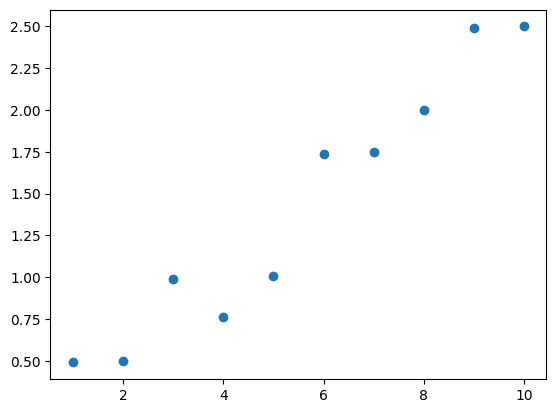

In [2]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y = [0.49, 0.5, 0.99, 0.76, 1.01, 1.74, 1.75, 2, 2.49, 2.5]
plt.plot(x, y, 'o')
plt.show()

First we define what type of fitting function to use. Here we will use the subclass `line`, defined in `fitting_functions_general.py`.

In [3]:
fitfunc = fit.line()
fitfunc.print_parameters()

Parameters:
'm'
'b'


The function `line` has two parameters, `m` and `b`, and the function is defined by `y = mx+b`.

The first step of using a `function_fitter` is to define which parameters are fixed. For the rest of the parameters, which is are taken to be free fitting parameters, we must define an initial guess value, as follows. Suppose in this case we know that the line must go through the origin, so we set the parameter `b` to be fixed to 0.

In [4]:
fitfunc.set_fixed_params({'b':0})
fitfunc.set_guess_params({'m':0.4})

In both cases, we define these parameters with a dictionary. This dictionary construction allows you to refer to the parameters by name rather than having to remember some order in the function definition.

There's a convenience function `eval_with_guesses` to help you see how good of a guess the guesses are, which is important because sometimes `scipy.curve_fit` needs those guesses to be reasonably close. Just pass in some x-values and the `function_fitter` object will evaluate the y-values given the fixed and guess parameters we just defined.

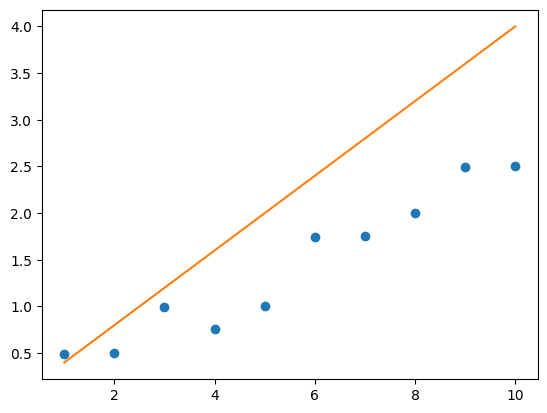

In [5]:
y_fit_guess = fitfunc.eval_with_guesses(x)
plt.plot(x, y, 'o')
plt.plot(x, y_fit_guess)
plt.show()

Now all that's left is to do the fit! Here we need to pass in the x and y data that we're fitting to as arguments.

In [6]:
fitfunc.do_fit(x, y)

{'m': (0.25623376574289436, 0.00976844402272327)}

The result is a dictionary, with one element for each free fitting parameter. The key of that element is the name of that parameter, and the value is a 2-tuple: the first value is the fitted value, and the second is the uncertainty.

The fit values are now also stored internally in the `function_fitter` object so that it remembers them. We can use the convenience function `eval_with_fits` to see what the fitted function returns as y-values given some x-values.

In [7]:
fits = fitfunc.get_fits()
fits

{'m': (0.25623376574289436, 0.00976844402272327)}

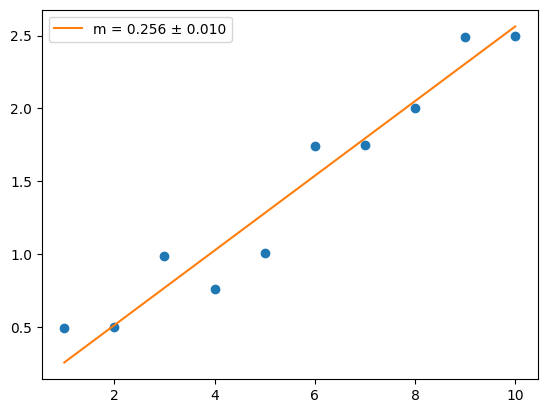

In [8]:
y_fit = fitfunc.eval_with_fits(x)
plt.plot(x, y, 'o')
plt.plot(x, y_fit, label='m = {0:.3f} ± {1:.3f}'.format(fits['m'][0], fits['m'][1]))
plt.legend()
plt.show()

## Two free fitting parameters

Now let's suppose instead we wanted to leave the y-intercept as a free fitting parameter rather than fixing it at zero. Now we simply pass in an empty dictionary to `set_fixed_params` since we aren't fixing any parameters, and include the parameter `b` in the dictionary when setting the guess parameters.

In [9]:
fitfunc.set_fixed_params({})
fitfunc.set_guess_params({'m':0.4, 'b':0.0})
fits = fitfunc.do_fit(x, y)
print(fits)

{'m': (0.24709090878054527, 0.022083239380247432), 'b': (0.06399999857233722, 0.1370228986245438)}


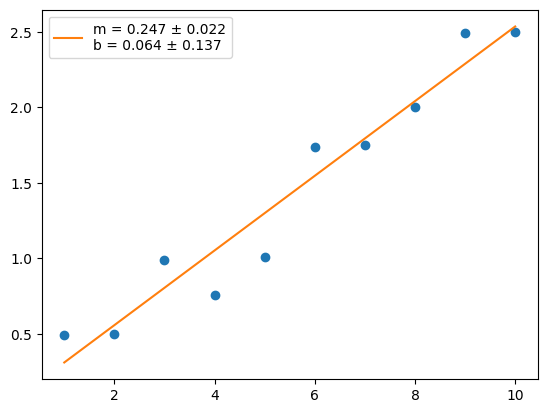

In [10]:
y_fit = fitfunc.eval_with_fits(x)
plt.plot(x, y, 'o')
plt.plot(x, y_fit, label='m = {0:.3f} ± {1:.3f}\nb = {2:.3f} ± {3:.3f}'.format(fits['m'][0], fits['m'][1], fits['b'][0], fits['b'][1]))
plt.legend()
plt.show()

## Setting bounds on fitting parameters

`scipy.curve_fit` lets you set bounds on the parameters being fit to. This is useful for example to help the solver not have to explore a parameter space larger than what you know is possible. To set this with a `function_fitter` object, call the function `set_fit_bounds`.

Suppose we want to enforce that the y-intercept is negative:

In [11]:
fitfunc.set_fixed_params({})
fitfunc.set_guess_params({'m':0.4, 'b':0.0})
fitfunc.set_fit_bounds({'b':(-np.inf, 0)})

The argument passed into the function `set_fit_bounds` should be a dictionary of parameters like the others, except that the value of each element should be a 2-tuple rather than a single value, indicating the upper and lower bound that the fitter is allowed to use. `np.inf and -np.inf can be used to indicate no upper or lower bound, respectively.

The elements of the dictionary passed into `set_fit_bounds` must be a subset of the free fitting parameters.

Now if we try a fit:

In [12]:
fitfunc.set_fixed_params({})
fitfunc.set_guess_params({'m':0.4, 'b':0.0})
fits = fitfunc.do_fit(x, y)
print(fits)

{'m': (0.2562337662342632, 0.022382317189865535), 'b': (-3.4786007380705553e-12, 0.13887862588364125)}


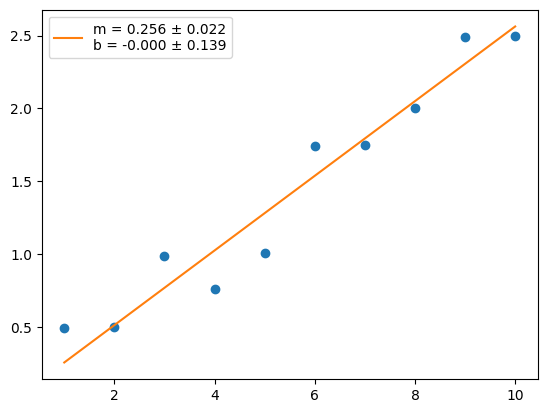

In [13]:
y_fit = fitfunc.eval_with_fits(x)
plt.plot(x, y, 'o')
plt.plot(x, y_fit, label='m = {0:.3f} ± {1:.3f}\nb = {2:.3f} ± {3:.3f}'.format(fits['m'][0], fits['m'][1], fits['b'][0], fits['b'][1]))
plt.legend()
plt.show()

## Including data error bars

`scipy.curve_fit` allows you to define how strongly to weigh each data point given error bars associated with each data point. The function `function_fitter.do_fit` allows you to use this functionality by passing in an optional keyword argument `yerr` to define the y-error.

Suppose our sample data has some associated error bars.

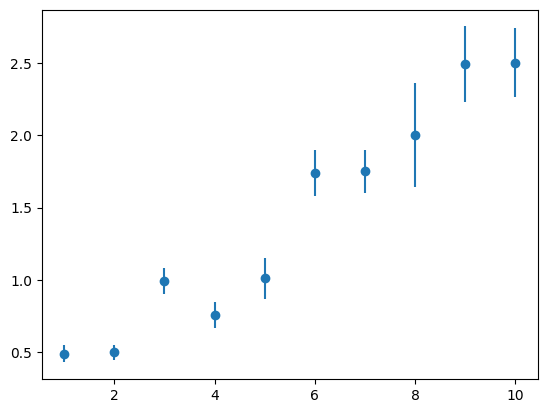

In [14]:
dy = [0.06, 0.05, 0.09, 0.09, 0.14, 0.16, 0.15, 0.36, 0.26, 0.24]
plt.errorbar(x, y, dy, linestyle='', marker='o')
plt.show()

Let's fit this data including the error bars, with no bounds on the fitting parameters this time.

In [15]:
fitfunc.set_fixed_params({})
fitfunc.set_guess_params({'m':0.4, 'b':0.0})
fitfunc.set_fit_bounds({})
fits = fitfunc.do_fit(x, y, yerr=dy)
print(fits)

{'m': (0.2215210468131962, 0.014997528636224399), 'b': (0.1418868112115259, 0.052076569950589555)}


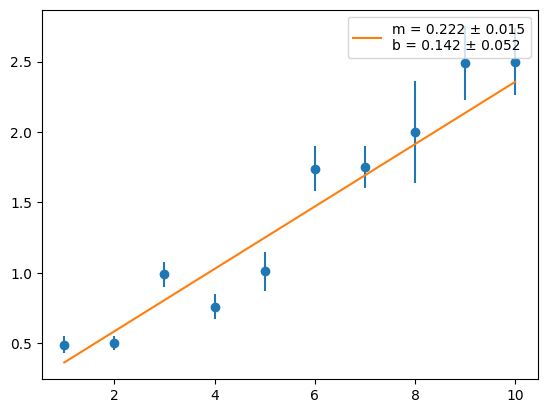

In [16]:
y_fit = fitfunc.eval_with_fits(x)
plt.errorbar(x, y, dy, linestyle='', marker='o')
plt.plot(x, y_fit, label='m = {0:.3f} ± {1:.3f}\nb = {2:.3f} ± {3:.3f}'.format(fits['m'][0], fits['m'][1], fits['b'][0], fits['b'][1]))
plt.legend()
plt.show()

The fit now prioritizes fitting closer to the data points with smaller error bars, resulting in this case in a smaller slope and larger y-intercept than otherwise.

# Rabi flop fit example with quantum projection noise

Here's a more real example with Rabi flop data.

See `tutorial1_importing_labrad_data.ipynb` for a walkthrough on importing data with the `labrad_data_tools` package.

In [17]:
import labrad_data_tools as ldt

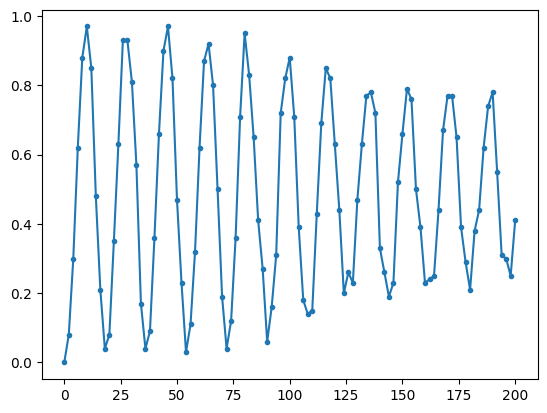

In [18]:
(x, y) = ldt.get_data('20240514', '1405.47')
plt.plot(x, y, '.-')
plt.show()

In [19]:
fitfunc = fit.rabi_flop_thermal()
fitfunc.print_parameters()

Parameters:
'Omega_kHz'
'delta_kHz'
'eta'
'sideband_order'
'scale'
'nbar'
'turnon_delay_us'


In [20]:
fitfunc.set_fixed_params({'delta_kHz': 0.0,
                          'eta': 0.069,
                          'sideband_order': 0,
                          'scale': 1.0,
                          'turnon_delay_us': 0.0})

fitfunc.set_guess_params({'nbar': 10.0,
                          'Omega_kHz': 50.0})

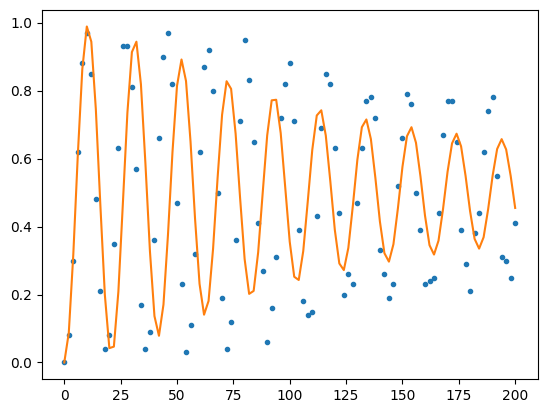

In [21]:
y_fit_guess = fitfunc.eval_with_guesses(x)
plt.plot(x, y, '.')
plt.plot(x, y_fit_guess)
plt.show()

That guess Rabi frequency is a little too slow and the guess temperature is a little too high. This fit might get stuck in a local optmimum due to all the oscillations. Let's try another guess.

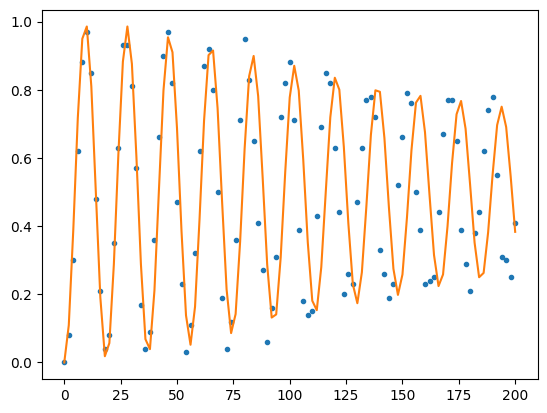

In [22]:
fitfunc.set_guess_params({'nbar': 5.0,
                          'Omega_kHz': 55.0})

y_fit_guess = fitfunc.eval_with_guesses(x)
plt.plot(x, y, '.')
plt.plot(x, y_fit_guess)
plt.show()

That looks closer. Let's try with that.

In [23]:
fits = fitfunc.do_fit(x, y)
print(fits)

{'Omega_kHz': (56.622838159813575, 0.04237662194467617), 'nbar': (4.912632987248469, 0.2382874725680255)}


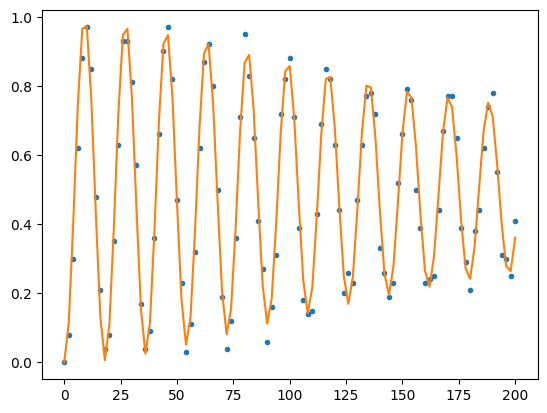

In [24]:
y_fit = fitfunc.eval_with_fits(x)
plt.plot(x, y, '.')
plt.plot(x, y_fit)
plt.show()

Here the fit tells us that the temperature is nbar = 4.91 ± 0.24.

What if we want to account for error bars in this data? In the absence of other noise, raw data points will be subject to quantum projection noise, which is worst when the excitation probability is close to 0.5. In general, for $N$ experiment repetitions, one expects the standard deviation of a data point with excitation $p$ to be

$$ \sigma = \sqrt{\frac{p(1-p)}{N}}. $$

One way to account for this is to define the error bars according to this formula and pass it in as the keyword argument `yerr` in `do_fit`. This data was taken with 100 repetitions.

In [25]:
N = 100
dy = np.maximum(np.sqrt(y*(1.0-y)/N), 1.0/(N+2)) # If p is exactly 0 or 1, take the standard deviation to be 1/(N+2) rather than 0.

In [26]:
fits = fitfunc.do_fit(x, y, yerr=dy)
print(fits)

{'Omega_kHz': (56.57646411226537, 0.03553290432170336), 'nbar': (4.5700124003980935, 0.17327106778263482)}


This result is slightly different.

The `function_fitter` class has a built-in tool to do this. If the data you're fitting to has probabilities on the y-axis and you want to use quantum projection noise as the error bars, then you don't have to calculate the standard deviations yourself; you can instead set the boolean keyword argument `use_qpn=True` in the `do_fit` function. Doing this is exactly equivalent to passing in the quantum projection noise values as the keyword argument for `yerr`.

In [27]:
fits = fitfunc.do_fit(x, y, use_qpn=True)
print(fits)

{'Omega_kHz': (56.57646411226537, 0.03553290432170336), 'nbar': (4.5700124003980935, 0.17327106778263482)}


Of course, if the data y-axis is not excitation probabilities, you should set `use_qpn=True` (default value is false). If `use_qpn` is set to `True`, and something is passed in for `yerr` for some reason, then `yerr` is ignored and quantum projection noise is calculated and used as the error bars.

# Seeing available functions

In general, you can show the list of available fitting functions to use like this:

In [28]:
fit.print_functions()

Options:
cosine()
diffusion()
double_gaussian()
exponential3_decay()
exponential3_decay_wcontrastosc()
exponential_decay()
gaussian()
gaussian_decay()
line()
lorentzian()
parity_scan()
phase_scan()
poissonian()
poissonian2()
power_law()
quadrupole_scan()
rabi_flop_thermal()
ramsey_decay()
rot_rabi_flop()
rot_rabi_flop_with_finite_nbar()
rot_ramsey_decay()
rot_ramsey_decay_echo()
rot_ramsey_decay_general()
sinc_squared()
spectrum()
spectrum_2level()


To see the parameters associated with any one of them, create an instance and call `print_parameters()`:

In [29]:
lor = fit.lorentzian()
lor.print_parameters()

Parameters:
'center'
'scale'
'fwhm'
'offset'


Note that there are some functions in the above list that are specific to spacetime. That's because the functions available are a combination of those defined in `fitting_functions_general.py`, which is intended to be part of the git repo and contains general functions that could be useful to anyone, and `fitting_functions_special.py`, which is intended to be more of a configuration file where you can define fitting functions that are useful to you.